# 3.1 Shortest Path
Let's start by testing the biological hypothesis that the tumorigenic genes are closer to one another in the protein interaction graph using a well-known measure of distance- the shortest path. Calculate the average shortest path between the tumorigenic genes and use this single scalar value as a score of network proximity for this set. 

Next, you would like to evaluate if this score is low, specifically, if it is lower than expected by chance. To do so, compute a background score for sets of non-tumorigenic genes (sets of the same size as your original set of tumorigenic genes). Calculate the average shortest path between the genes in such sets. Intuitively, it should be much longer than the proteins that are actually involved in the oncogenic process. 

Build 1000 random sets to establish a background distribution of average shortest paths scores and either confirm or reject the hypothesis that tumorigenic genes are closer to one another. Make sure to plot the distribution, calculate a p-value, and provide an explanation for the observed result.

Observed avg shortest-path: 5.667
Null mean: 6.052
P-value (fraction ≤ observed): 0.3947


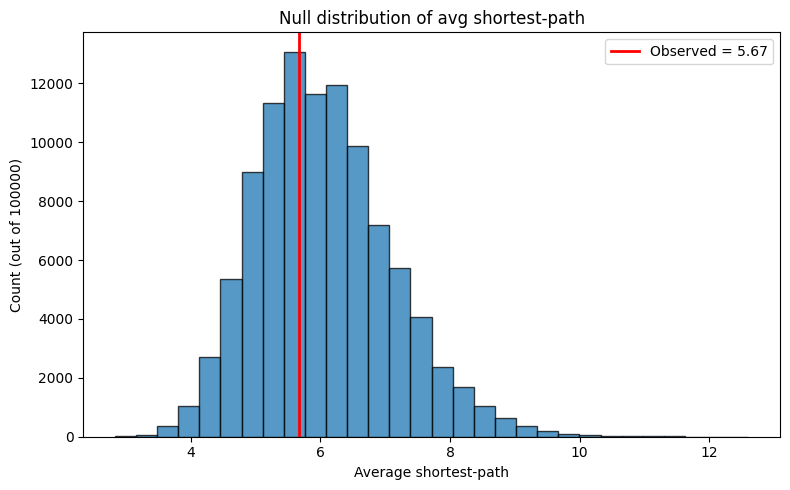

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from itertools import combinations

# 1) Load the PPI graph
G = nx.Graph()
with open('interacting_proteins.txt') as f:
    for line in f:
        u, v = line.strip().split()
        G.add_edge(u, v)

# 2) Load known drivers
with open('onco_genes.txt') as f:
    oncogenes = [g.strip() for g in f if g.strip()]
oncogenes = [g for g in oncogenes if g in G]
if len(oncogenes) < 2:
    raise RuntimeError("Need at least two oncogenes present in the graph")

# 3) Helper to compute avg shortest-path over all pairs
def avg_shortest_path(nodes):
    dists = []
    for a, b in combinations(nodes, 2):
        try:
            dists.append(nx.shortest_path_length(G, a, b))
        except nx.NetworkXNoPath:
            pass
    return np.mean(dists)

# 4) Observed score
obs_score = avg_shortest_path(oncogenes)
print(f"Observed avg shortest-path: {obs_score:.3f}")

# 5) Null distribution (using numpy.random)
all_nodes  = np.array(list(G.nodes()))
mask       = ~np.isin(all_nodes, oncogenes)
candidates = all_nodes[mask]

# fix seed for reproducibility
rng = np.random.default_rng(2)

null_scores = []
randomization = 100000
for _ in range(randomization):
    sample = rng.choice(candidates, size=len(oncogenes), replace=False)
    null_scores.append(avg_shortest_path(sample))
null_scores = np.array(null_scores)

# 6) Compute p-value
p_value = np.mean(null_scores <= obs_score)
print(f"Null mean: {null_scores.mean():.3f}")
print(f"P-value (fraction ≤ observed): {p_value:.4f}")

# 7) Plot the null distribution
plt.figure(figsize=(8,5))
plt.hist(null_scores, bins=30, alpha=0.75, edgecolor='k')
plt.axvline(obs_score, color='red', linewidth=2,
            label=f'Observed = {obs_score:.2f}')
plt.xlabel('Average shortest-path')
plt.ylabel(f'Count (out of {randomization})')
plt.title('Null distribution of avg shortest-path')
plt.legend()
plt.tight_layout()
plt.show()

# Graph Diffusion and Random Walks
Using a random walk algorithm to determing network connections

## Toy Example

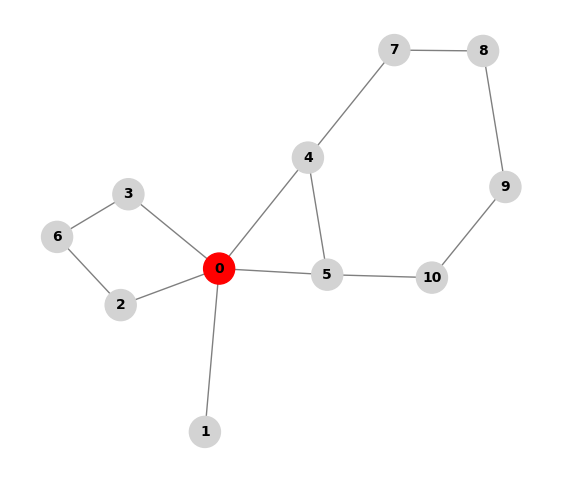

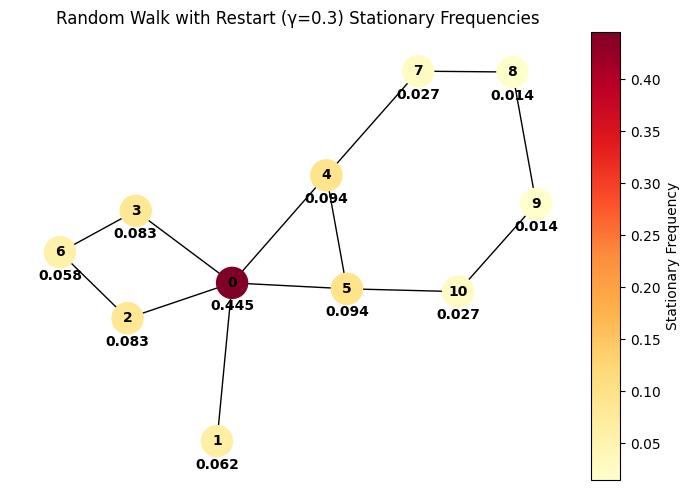

In [39]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

G = nx.Graph()
edges = [
    (0, 1), 
    (0, 2), 
    (0, 3), 
    (0, 4), 
    (0, 5), 
    (2, 6), 
    (3, 6),
    (4, 5),
    (4, 7),
    (7, 8),
    (8, 9),
    (9, 10),
    (10, 5),
]
G.add_edges_from(edges)

gamma = 0.3             # restart probability
start_node = 0         
pos = nx.spring_layout(G, seed=2) 
nodes = list(G.nodes())
n = len(nodes)
idx = {node: i for i, node in enumerate(nodes)}

plt.figure(figsize=(7,6))
node_colors = ['red' if node == start_node else 'lightgray' for node in nodes]
nx.draw_networkx_nodes(G, pos, node_size=500, node_color=node_colors)
nx.draw_networkx_edges(G, pos, alpha=0.5)
nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold')
plt.axis('off')
plt.show()

# --- 2) Compute RWR stationary frequencies ---
A = nx.to_numpy_array(G, nodelist=nodes)
deg = A.sum(axis=1)
P = np.zeros_like(A)
for i in range(n):
    if deg[i] > 0:
        P[i, :] = A[i, :] / deg[i]

e = np.zeros(n)
e[idx[start_node]] = 1
p = e.copy()

tol = 1e-6
for _ in range(1000):
    p_new = (1 - gamma) * P.T.dot(p) + gamma * e
    if np.linalg.norm(p_new - p, 1) < tol:
        p = p_new
        break
    p = p_new

stationary = {nodes[i]: p[i] for i in range(n)}

# --- 3) RWR heatmap plot (same size) ---
fig, ax = plt.subplots(figsize=(7,5))
values = np.array([stationary[node] for node in nodes])

# prepare the color‐mapper
sm = plt.cm.ScalarMappable(
    cmap=plt.cm.YlOrRd,
    norm=plt.Normalize(vmin=values.min(), vmax=values.max())
)
sm.set_array(values)

# draw nodes & edges
nx.draw_networkx_nodes(
    G, pos,
    node_color=values,
    cmap=plt.cm.YlOrRd,
    node_size=500,
    ax=ax
)
nx.draw_networkx_edges(G, pos, ax=ax)

# inline colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(sm, cax=cax, label='Stationary Frequency')

# annotate: ID centered, score below
offset = 0.04
for node in nodes:
    x, y = pos[node]
    # draw the node ID at center
    ax.text(
        x, y,
        str(node),
        horizontalalignment='center',
        verticalalignment='center',
        fontsize=10,
        fontweight='bold'
    )
    # draw the stationary score just below
    ax.text(
        x, y - offset,
        f"{stationary[node]:.3f}",
        horizontalalignment='center',
        verticalalignment='top',
        fontsize=10,
        fontweight='bold'
    )

ax.set_title("Random Walk with Restart (γ=0.3) Stationary Frequencies")
ax.set_axis_off()
fig.tight_layout()
plt.show()


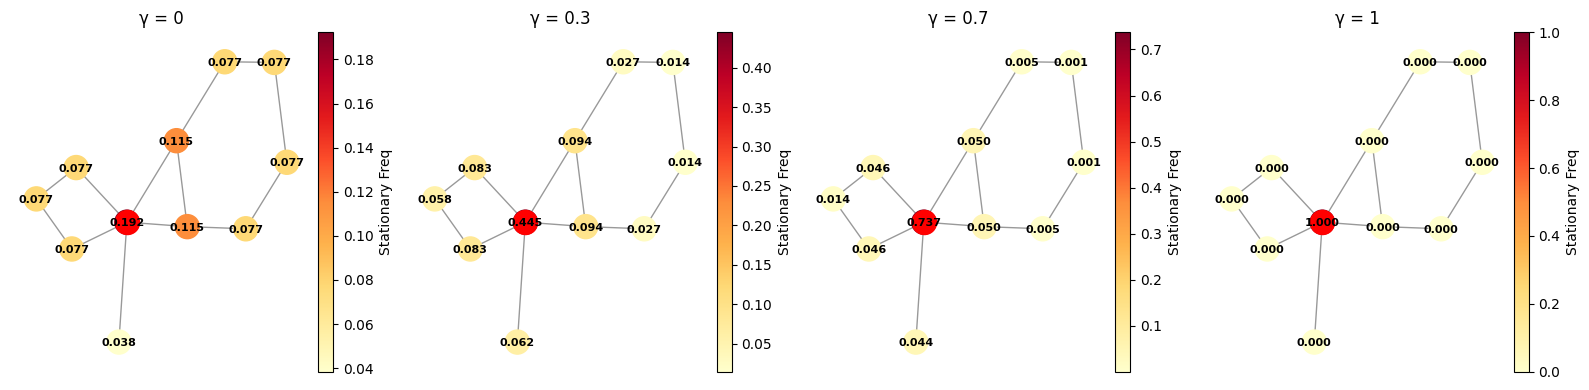

In [45]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from mpl_toolkits.axes_grid1 import make_axes_locatable

# --- build the toy graph ---
G = nx.Graph()
edges = [
    (0, 1), (0, 2), (0, 3), (0, 4), (0, 5),
    (2, 6), (3, 6), (4, 5), (4, 7),
    (7, 8), (8, 9), (9, 10), (10, 5),
]
G.add_edges_from(edges)

edge_weights = {e: 1.0 for e in edges}
for (u, v), w in edge_weights.items():
    G[u][v]['weight'] = w

# common setup
start_node = 0
nodes = list(G.nodes())
n = len(nodes)
idx = {node: i for i, node in enumerate(nodes)}
pos = nx.spring_layout(G, seed=2)

# build weighted transition matrix P once
A = nx.to_numpy_array(G, nodelist=nodes, weight='weight')
deg = A.sum(axis=1)
P = np.divide(A, deg[:, None], out=np.zeros_like(A), where=deg[:, None]>0)

# restart vector
e = np.zeros(n)
e[idx[start_node]] = 1

# values of gamma to sweep
gammas = [0, 0.3, 0.7, 1]

# create subplots
fig, axes = plt.subplots(1, len(gammas), figsize=(4*len(gammas), 4))
if len(gammas) == 1:
    axes = [axes]

for ax, gamma in zip(axes, gammas):
    # power‐iteration
    p = e.copy()
    tol = 1e-6
    for _ in range(1000):
        p_new = (1 - gamma)*P.T.dot(p) + gamma*e
        if np.linalg.norm(p_new - p, 1) < tol:
            p = p_new
            break
        p = p_new

    # collect stationary values
    values = np.array([p[idx[node]] for node in nodes])

    # draw nodes
    nc = nx.draw_networkx_nodes(
        G, pos,
        node_color=values,
        cmap=plt.cm.YlOrRd,
        node_size=300,
        ax=ax
    )
    nx.draw_networkx_edges(G, pos, alpha=0.4, ax=ax)
    for node in nodes:
        x, y = pos[node]
        ax.text(
            x, y,
            f"{p[idx[node]]:.3f}",
            ha='center', va='center_baseline',
            fontsize=8,
            fontweight='bold'
        )
    nx.draw_networkx_nodes(
        G.subgraph([start_node]),
        pos,
        node_color='red',
        node_size=300,
        ax=ax
    )

    ax.set_title(f"γ = {gamma}")
    ax.set_axis_off()

    # inline colorbar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(nc, cax=cax, label='Stationary Freq')

plt.tight_layout()
plt.show()


# Varrying Weights

Change the weights on some of the edges. Do you observe changes in the stationary frequencies consistent with the direction in which the weighted edges are likely to be sending the walk to. Discuss in your report

Column sums (should all be 1):
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Weight matrix W:
[[0.    1.    0.45  0.345 0.068 0.233 0.    0.    0.    0.    0.   ]
 [0.315 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.245 0.    0.    0.    0.    0.    0.167 0.    0.    0.    0.   ]
 [0.105 0.    0.    0.    0.    0.    0.833 0.    0.    0.    0.   ]
 [0.151 0.    0.    0.    0.    0.716 0.    0.826 0.    0.    0.   ]
 [0.184 0.    0.    0.    0.155 0.    0.    0.    0.    0.    0.587]
 [0.    0.    0.55  0.655 0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.778 0.    0.    0.    0.604 0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.174 0.    0.624 0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.396 0.    0.413]
 [0.    0.    0.    0.    0.    0.051 0.    0.    0.    0.376 0.   ]]


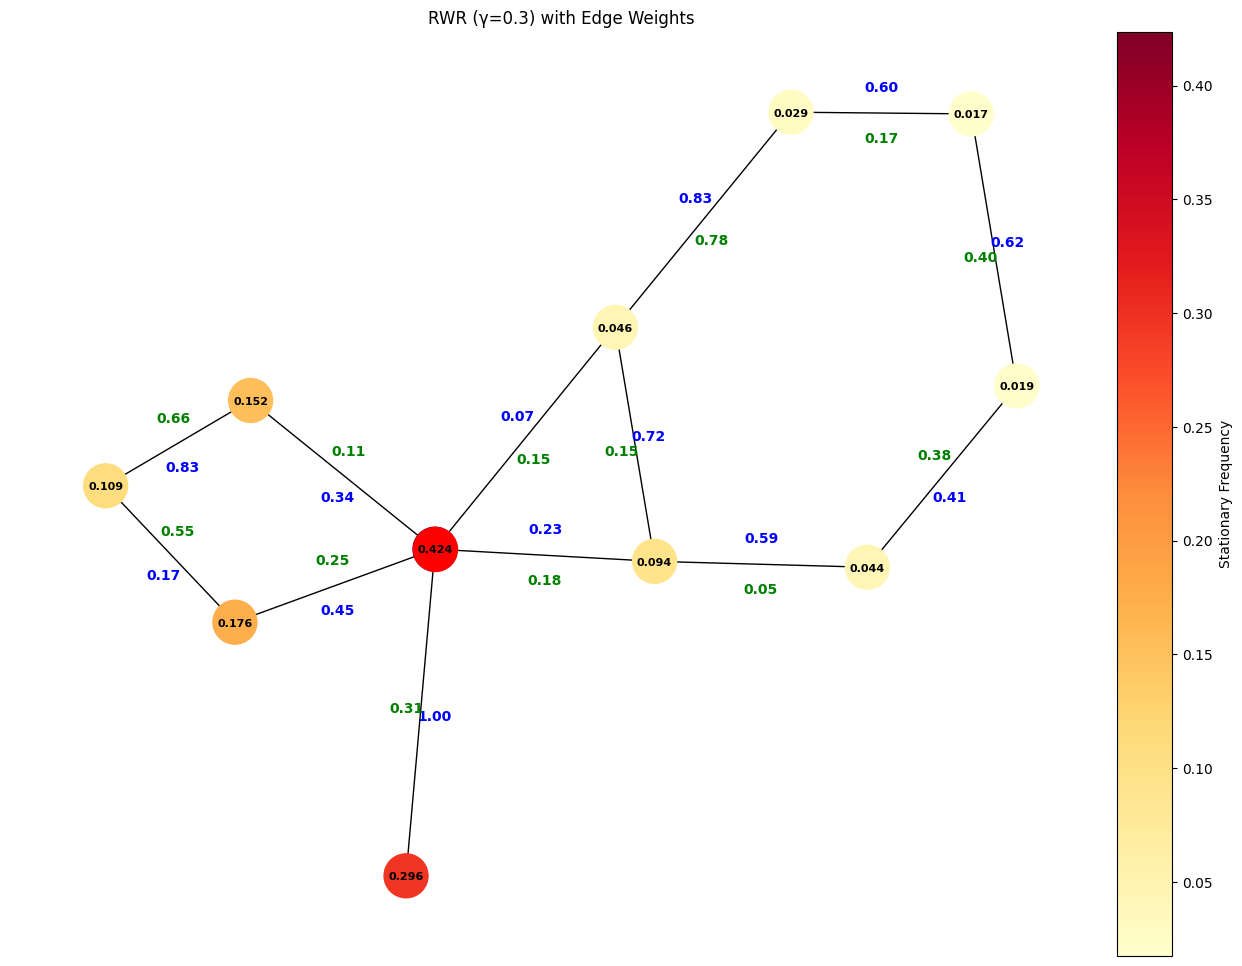

In [59]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable


# 1) Build the graph
G = nx.Graph()
edges = [
    (0, 1), (0, 2), (0, 3), (0, 4), (0, 5),
    (2, 6), (3, 6), (4, 5), (4, 7),
    (7, 8), (8, 9), (9, 10), (10, 5),
]
G.add_edges_from(edges)

# 2) Adjacency mask
A = nx.to_numpy_array(G, dtype=int)

# 3) Random column-stochastic weight generator
def random_weights(adj, low=0.0, high=1.0):
    """
    adj:    (N,N) 0/1 adjacency mask
    Returns W so that:
      - W[i,j] > 0 only if adj[i,j]==1
      - sum_i W[i,j] == 1 for every column j that has at least one edge
    """
    rng = np.random.default_rng()
    N = adj.shape[0]

    # Sample raw weights only on existing edges
    W = np.zeros((N, N), dtype=float)
    mask = adj > 0
    W[mask] = rng.uniform(low, high, size=mask.sum())

    # Normalize each column explicitly
    for j in range(N):
        s = W[:, j].sum()
        if s > 0:
            W[:, j] /= s

    return W

W = random_weights(A, low=0, high=1)
column_sums = W.sum(axis=0)

print("Column sums (should all be 1):")
print(column_sums)

print("\nWeight matrix W:")
print(np.round(W, 3))

P = W  # P is now column-stochastic

# 5) RWR parameters
gamma = 0.3
start_node = 0
nodes = list(G.nodes())
n = len(nodes)
idx = {node: i for i, node in enumerate(nodes)}

# 6) Restart vector
e = np.zeros(n)
e[idx[start_node]] = 1

# 7) Power-iteration to convergence
p = e.copy()
tol = 1e-6
for _ in range(10000):
    p_new = (1 - gamma) * P.T.dot(p) + gamma * e
    if np.linalg.norm(p_new - p, 1) < tol:
        p = p_new
        break
    p = p_new

# 8) Stationary frequencies
values = [p[idx[node]] for node in nodes]

# --- 4) Plot with edge-weight annotations ---
pos = nx.spring_layout(G, seed=2)
fig, ax = plt.subplots(figsize=(15, 12))

# Draw nodes colored by stationary freq
values = [p[idx[node]] for node in nodes]
nc = nx.draw_networkx_nodes(G, pos, node_color=values,
                            cmap=plt.cm.YlOrRd, node_size=1000, ax=ax)
nx.draw_networkx_edges(G, pos, ax=ax)
nx.draw_networkx_nodes(G.subgraph([start_node]), pos,
                       node_color='red', node_size=1000, ax=ax)

# Annotate node labels
for node in nodes:
    x, y = pos[node]
    ax.text(
            x, y,
            f"{p[idx[node]]:.3f}",
            ha='center', va='center_baseline',
            fontsize=8,
            fontweight='bold'
        )

for u, v in G.edges():
    x1, y1 = pos[u]
    x2, y2 = pos[v]
    xm, ym = (x1 + x2) / 2, (y1 + y2) / 2
    dx, dy = x2 - x1, y2 - y1
    length = np.hypot(dx, dy)
    ux, uy = -dy / length, dx / length  # perpendicular unit

    # u→v label above edge
    offset = 0.03
    ax.text(
        xm + ux * offset, ym + uy * offset,
        f"{W[u, v]:.2f}",
        ha='center', va='center',
        fontsize=10, fontweight='bold', color='blue'
    )
    # v→u label below edge
    ax.text(
        xm - ux * offset, ym - uy * offset,
        f"{W[v, u]:.2f}",
        ha='center', va='center',
        fontsize=10, fontweight='bold', color='green'
    )


# Inline colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(nc, cax=cax, label='Stationary Frequency')

ax.set_title("RWR (γ=0.3) with Edge Weights")
ax.set_axis_off()
plt.show()

# 
Now 1 example of it with random weights and changing gamma

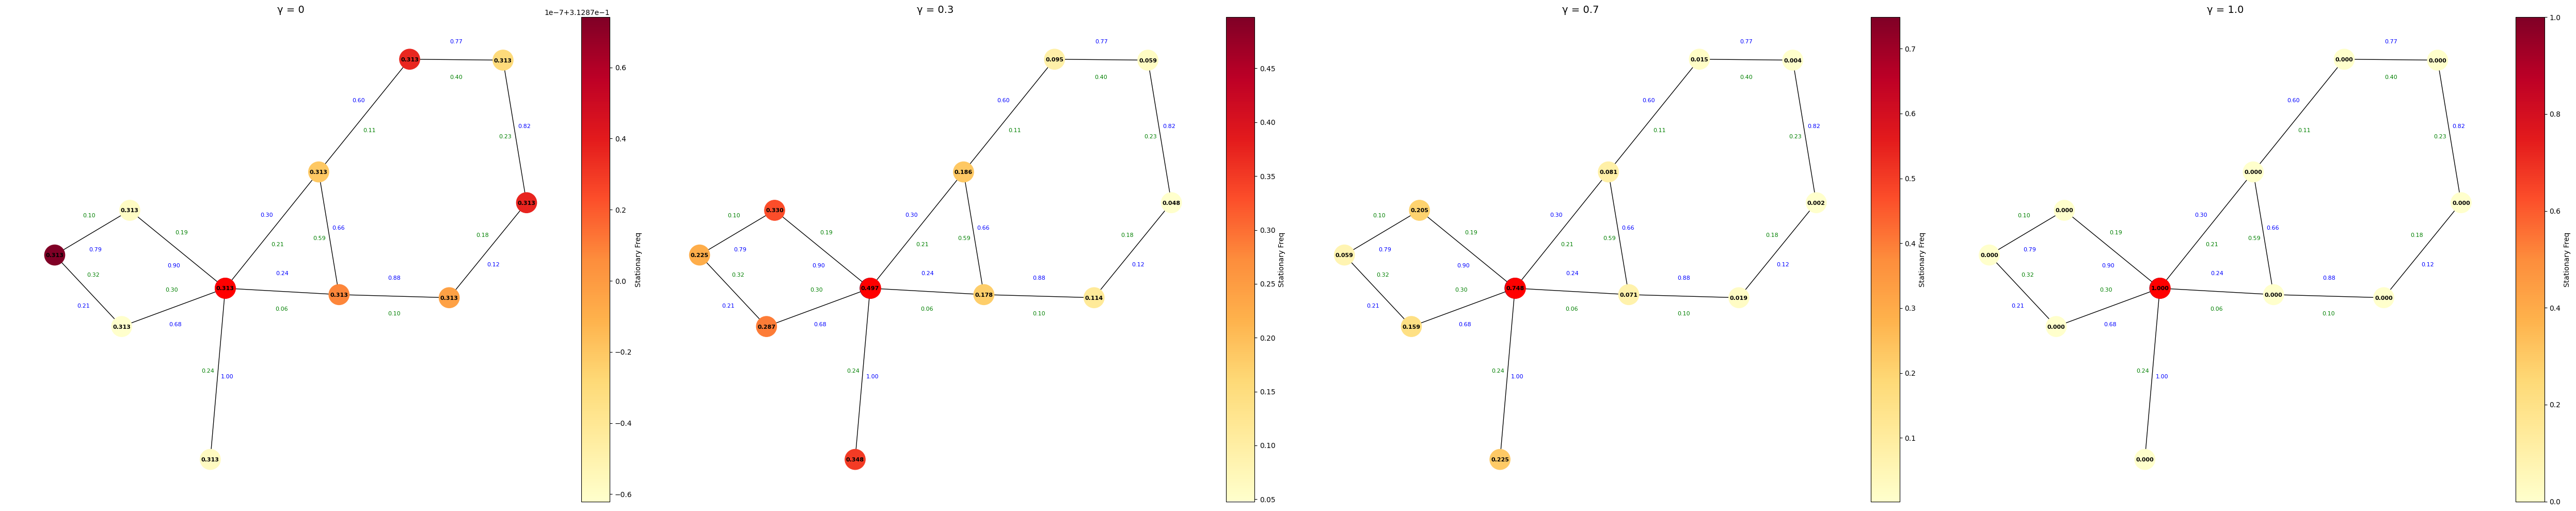

In [64]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# 1) Build the graph and adjacency mask
G = nx.Graph()
edges = [
    (0, 1), (0, 2), (0, 3), (0, 4), (0, 5),
    (2, 6), (3, 6), (4, 5), (4, 7),
    (7, 8), (8, 9), (9, 10), (10, 5),
]
G.add_edges_from(edges)
A = nx.to_numpy_array(G, dtype=int)

# 2) Random column-stochastic weight generator
def random_weights(adj, low=0.0, high=1.0):
    rng = np.random.default_rng()
    N = adj.shape[0]
    W = np.zeros((N, N), dtype=float)
    mask = adj > 0
    W[mask] = rng.uniform(low, high, size=mask.sum())
    for j in range(N):
        s = W[:, j].sum()
        if s > 0:
            W[:, j] /= s
    return W

# Generate W and use it as transition matrix P
W = random_weights(A, low=0, high=1)
P = W  # column-stochastic

# 3) RWR setup
start_node = 0
nodes = list(G.nodes())
n = len(nodes)
idx = {node: i for i, node in enumerate(nodes)}
e = np.zeros(n)
e[idx[start_node]] = 1

# 4) Gammas to evaluate
gammas = [0, 0.3, 0.7, 1.0]

# 5) Prepare layout
pos = nx.spring_layout(G, seed=2)

# 6) Create subplots
fig, axes = plt.subplots(1, len(gammas), figsize=(50, 10))

for ax, gamma in zip(axes, gammas):
    # Power iteration
    p = e.copy()
    tol = 1e-6
    for _ in range(10000):
        p_new = (1 - gamma) * P.T.dot(p) + gamma * e
        if np.linalg.norm(p_new - p, 1) < tol:
            p = p_new
            break
        p = p_new

    # Node values
    values = [p[idx[node]] for node in nodes]

    # Draw nodes and edges
    nc = nx.draw_networkx_nodes(
        G, pos, node_color=values, cmap=plt.cm.YlOrRd,
        node_size=800, ax=ax
    )
    nx.draw_networkx_edges(G, pos, ax=ax)
    nx.draw_networkx_nodes(
        G.subgraph([start_node]), pos,
        node_color='red', node_size=800, ax=ax
    )

    # Annotate nodes with stationary freq
    for node in nodes:
        x, y = pos[node]
        ax.text(x, y, f"{p[idx[node]]:.3f}", ha='center', va='center_baseline',
                fontsize=8, fontweight='bold')

    # Annotate edge weights
    offset = 0.04
    for u, v in G.edges():
        x1, y1 = pos[u]
        x2, y2 = pos[v]
        xm, ym = (x1 + x2) / 2, (y1 + y2) / 2
        dx, dy = x2 - x1, y2 - y1
        length = np.hypot(dx, dy)
        ux, uy = -dy / length, dx / length  # perpendicular unit

        # u→v
        ax.text(xm + ux * offset, ym + uy * offset,
                f"{W[u, v]:.2f}", ha='center', va='center',
                fontsize=8, color='blue')
        # v→u
        ax.text(xm - ux * offset, ym - uy * offset,
                f"{W[v, u]:.2f}", ha='center', va='center',
                fontsize=8, color='green')

    # Colorbar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    fig.colorbar(nc, cax=cax, label='Stationary Freq')

    ax.set_title(f"γ = {gamma}", fontsize=14)
    ax.axis('off')

plt.tight_layout()
plt.show()


# Ranked Nodes
Rank the nodes based on their degree, how does this ranking correlate with the stationary distribution ranking of the nodes (especially in the case γ = 1 ). Spearman rank correlation test might be helpful here.

# 4.2 Real Data
Once you have your code streamlined and you are confident it works properly, move to the real data.

Use the random walk with restarts (RWR) algorithm (or diffusion if desired) to calculate an average network proximity measure for the set of known tumorigenic genes. Specifically, run a RWR starting from one tumorigenic node and calculate the stationary frequencies for all other tumorigenic gens. Intuitively, if they are close within the network, these frequencies should be high and, more importantly, higher than the stationary frequencies of nodes not related to oncogenic processes. Repeat this for every tumorigenic node and calculate the average score. As in 3.1, establish a background rate- draw 1000 times random set of proteins and for each set calculate its network proximity score based on RWR. What does the background distribution look like and how extreme is the oncogenic nodes score (p-value)? Would you accept or reject the hypothesis that they are much closer in the graph according to the new metric?

Note: you may need to run your simulation for many more iterations to converge than in the toy example as the graph is much bigger.

# 4.2.3 Predict novel tumorigenic genes
Use your proximity scores derived from the RWR to implicate other genes that might be involved in the oncogenic process. Upload your top 30 predicted genes as single gene IDs, each on a new line in file: FirstName_LastName_onco_predictions.txt

# 4.3 Graph Randomization
Finally, to confirm the importance of the graphs structure, randomize the network using the degree preserving edge swapping technique from class. Now that the edges don't represent real interaction between the proteins but link random proteins instead, you shouldn't expect the tumorigenic nodes proteins to be in network proximity to one another. Test this intuition. Use the randomized network and repeat the analysis of 4.2. Does the network proximity score for the set of tumorigenic nodes differ from that of a random background set?